good reference for stacking: https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335
        

### Loading needed libs

In [31]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import *

from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import *
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.svm import SVC
from xgboost import XGBClassifier
from time import time
from keras.utils.np_utils import to_categorical  
from sklearn.linear_model import *
import lightgbm as lgb

### Finding the features

In [75]:
# make predictions for multinoulli NB
df = pd.read_csv('reddit_train.csv')
df2 = pd.read_csv('reddit_test.csv')
df = df.sample(frac=1)
# df = df.iloc[:3000,:]

In [76]:
df['category_id'], mapping = df['subreddits'].factorize()

In [91]:
# tfidf = HashingVectorizer()
tfidf = TfidfVectorizer()
features = tfidf.fit_transform(df.comments)
features_test = tfidf.transform(df2.comments)

labels = df.category_id

from sklearn.feature_selection import SelectKBest, chi2
SelectKBest(chi2, k=1000)

### Code for fine tuning and check which models are the best

0.01 0.4187
0.05 0.4995
0.1 0.52285
0.15 0.53295
0.2 0.53785
0.3 0.543
0.5 0.5456
1 0.5439


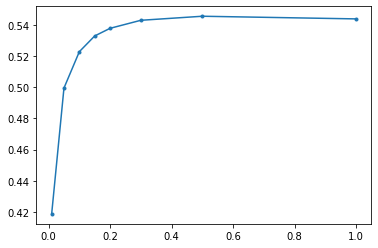

In [89]:
test_acc = []
vals = [0.01, 0.05, 0.1, 0.15, 0.20, 0.3, 0.5, 1]
for i in vals:
    gNB = LinearSVC(C=i)
    gNB.fit(features[:50000,:],labels[:50000])
    test_acc.append(np.mean(gNB.predict(features[50000:,:])==labels[50000:]))
    print(i, np.mean(gNB.predict(features[50000:,:])==labels[50000:]))
    
plt.plot(vals, test_acc, '.-')

0.01 0.5094
0.05 0.55265
0.1 0.5605
0.15 0.56225
0.2 0.56245
0.3 0.5611
0.5 0.55705
1 0.54765


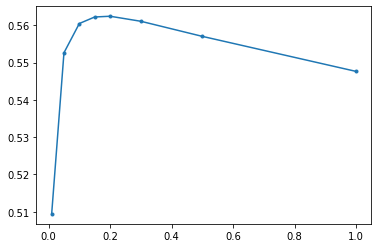

In [94]:
test_acc = []
vals = [0.01, 0.05, 0.1, 0.15, 0.20, 0.3, 0.5, 1]
for i in vals:
    gNB = LinearSVC(C=i)
    gNB.fit(features[:50000,:],labels[:50000])
    test_acc.append(np.mean(gNB.predict(features[50000:,:])==labels[50000:]))
    print(i, np.mean(gNB.predict(features[50000:,:])==labels[50000:]))
    
plt.plot(vals, test_acc, '.-')

### Extracting features from a sklearn model

In [22]:
def getFeatures(classifier):
    classifier.fit(features, labels)
    f1 = classifier.predict_proba(features)
    f2 = classifier.predict_proba(features_test)
    print(' training accuracy: ', np.mean(classifier.predict(features)==labels))
    return f1, f2

def getFeaturesOneHot(classifier):
    classifier.fit(features, labels)
    f1 = classifier.predict(features)
    f2 = classifier.predict(features_test)
    print(' training accuracy: ', np.mean(classifier.predict(features)==labels))
    return to_categorical(f1, num_classes=20), to_categorical(f2, num_classes=20)

In [54]:
m1_train, m1_test = getFeatures(MultinomialNB(0.15))
m2_train, m2_test = getFeatures(LogisticRegression(C=1))
m5_train, m5_test = getFeaturesOneHot(LinearSVC(C=0.2))
m9_train, m9_test = getFeaturesOneHot(RidgeClassifier())

 training accuracy:  0.8274571428571429


/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


 training accuracy:  0.7188571428571429
 training accuracy:  0.8332714285714286
 training accuracy:  0.876


### Extracting features from pytorch models (saved)

In [55]:
# load predictions
def pickle2np(filename="preds/bert-preds-test.p"):
    tmp = pickle.load( open( filename, "rb" ) )
    preds = list()
    for i in range(len(tmp)):
        for j in range(len(tmp[i])):
            preds.append(list(tmp[i][j]))
            
    return np.array(preds)

m3_train = pickle2np("preds/bert-preds-train.p")
m3_test = pickle2np("preds/bert-preds-test.p")
m4_train = pickle2np("preds/xlnet-preds-train.p")
m4_test = pickle2np("preds/xlnet-preds-test.p")

In [56]:
# m3_train = m3_train[:3000, :]
# m4_train = m4_train[:3000, :]

In [57]:
# stacking the features
features = np.concatenate((m1_train, m2_train, m3_train, m4_train, m5_train, m9_train),axis=1)
test_features = np.concatenate((m1_test, m2_test, m3_test, m4_test, m5_test, m9_test),axis=1)
labels = df.category_id

In [27]:
# uncomment if you want to work on a smaller sample
samples = np.random.randint(70000,size=(1000))
features = features[samples,:]
labels = df.category_id[samples]
features.shape

IndexError: index 24413 is out of bounds for axis 0 with size 3000

In [95]:
params = {
 'task': 'train'
 , 'boosting_type': 'gbdt'
 , 'objective': 'multiclass'
 , 'num_class': 20
 , 'metric': 'multi_logloss'
 , 'min_data': 1
 , 'verbose': -1
}

lgb_train = lgb.Dataset(features[:60000,:], labels[:60000])
lgb_eval = lgb.Dataset(features[60000:,:], labels[60000:], reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
y_pred = gbm.predict(features[60000:], num_iteration=gbm.best_iteration)
print('test_acc: ', np.mean(np.argmax(y_pred, axis=1)==labels[60000:]))

[1]	valid_0's multi_logloss: 2.74731
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 2.63327
[3]	valid_0's multi_logloss: 2.55403
[4]	valid_0's multi_logloss: 2.4936
[5]	valid_0's multi_logloss: 2.44358
[6]	valid_0's multi_logloss: 2.40013
[7]	valid_0's multi_logloss: 2.36346
[8]	valid_0's multi_logloss: 2.33169
[9]	valid_0's multi_logloss: 2.30372
[10]	valid_0's multi_logloss: 2.27753
[11]	valid_0's multi_logloss: 2.25549
[12]	valid_0's multi_logloss: 2.23416
[13]	valid_0's multi_logloss: 2.21476
[14]	valid_0's multi_logloss: 2.19644
[15]	valid_0's multi_logloss: 2.17966
[16]	valid_0's multi_logloss: 2.16431
[17]	valid_0's multi_logloss: 2.15013
[18]	valid_0's multi_logloss: 2.13587
[19]	valid_0's multi_logloss: 2.12357
[20]	valid_0's multi_logloss: 2.11102
[21]	valid_0's multi_logloss: 2.0989
[22]	valid_0's multi_logloss: 2.08789
[23]	valid_0's multi_logloss: 2.07726
[24]	valid_0's multi_logloss: 2.06872
[25]	valid_0's multi_logloss: 2.05929
[

In [28]:

models = [
#     RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
#     LogisticRegression(),
    LinearSVC(),
    XGBClassifier(),
#     AdaBoostClassifier(),
#     KNeighborsClassifier()
#     GaussianNB(),
#     KNeighborsClassifier(),
#     GradientBoostingClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    start_time = time()
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        print('fold_idx, accuracy: ', fold_idx, accuracy)
        entries.append((model_name, fold_idx, accuracy))
    print('time taken: ', time()-start_time)
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

LinearSVC


/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to c

fold_idx 0
fold_idx 1
fold_idx 2
fold_idx 3
fold_idx 4
time taken:  5.800466775894165
XGBClassifier
fold_idx 0
fold_idx 1
fold_idx 2
fold_idx 3
fold_idx 4
time taken:  51.430683612823486


In [30]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.998338,0.002018
XGBClassifier,0.996336,0.001387


### fine tuning the meta learner

In [29]:
for eta in [0.01, 0.1, 0.2, 0.3, 1]:
    gNB = XGBClassifier(learning_rate=eta)
    gNB.fit(features[:900,:],labels[:900])
    print(eta, np.mean(gNB.predict(features[900:,:])==labels[900:]))

0.01 0.89
0.1 0.9
0.2 0.88
0.3 0.88
1 0.85


### fit classifier on full dataset

In [15]:
print(features.shape,labels.shape)
reg = LinearSVC()
start_time = time()
reg.fit(features,labels)
print(time()-start_time)

(70000, 120) (70000,)
367.2468032836914


/network/home/penmetss/fastai/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [16]:
# get predictions and training accuracy
print(np.mean(reg.predict(features)==labels))
preds = reg.predict(test_features)

0.8848428571428572


In [17]:
preds.shape

(30000,)

In [18]:
test_preds = pd.DataFrame()
test_preds['Id'] = df2['id']
test_preds['Category'] = mapping[preds]


In [19]:
test_preds.to_csv("test.csv", index=False)
from IPython.display import FileLink, FileLinks
FileLink('test.csv')

/network/home/penmetss/comp551/test.csv